# SE_25 Data Science Hand-in 
---
Student name: Sijia Tang, Yutaro Koyama


# Dataset description
We use the dataset from [Kaggle](https://www.kaggle.com/competitions/birdclef-2021/data).  This dataset is a standardized version of some of the bird call audio data in [XenoCanto](https://xeno-canto.org/)

### train_metadata.csv
A wide range of metadata for the training data. 

The most directly relevant fields are:

- `primary_label`: a code for the bird species. You can review detailed information about the bird codes by appending the code to https://ebird.org/species/, such as https://ebird.org/species/amecro for the American Crow.
- `author`: the user who provided the recording.
- `latitude & longitude`: coordinates for where the recording was taken. Some bird species may have local call ‘dialects,’ so you may want to seek geographic diversity in your training data.
- `date`: while some bird calls can be made year round, such as an alarm call, some are restricted to a specific season. You may want to seek temporal diversity in your training data.
- `filename`: the name of the associated audio file.
- `scientific_name & common_name`: Scientific terms and common terms of bird name
- `time `: Time in the day when the audio was recorded
- `url` : original recording data url specified in xeno-canto
- `rating` : the quality of the audio recording


### train_short_audio
The bulk of the training data consists of short recordings of individual bird calls generously uploaded by users of [XenoCanto](https://xeno-canto.org/).org. These files have been downsampled to 32 kHz where applicable to match the test set audio and converted to the ogg format. The training data should have nearly all relevant files; we expect there is no benefit to looking for more on XenoCanto

# Environment Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install geopandas

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import geopandas as gpd
from geopy.geocoders import Nominatim
import plotly.express as px

In [5]:
BASE_PATH = '/content/drive/Shareddrives/Detecting bird sounds/birdclef-2021/'
AUDIO_PATH = '/content/drive/Shareddrives/Detecting bird sounds/birdclef-2021/train_short_audio/'

In [6]:
df = pd.read_csv(os.path.join(BASE_PATH,'train_metadata.csv'))
ss = pd.read_csv(os.path.join(BASE_PATH,'train_soundscape_labels.csv'))
cc = pd.read_csv(os.path.join(BASE_PATH,'countryContinent.csv'), header=0, encoding='unicode_escape')

# Data Exploration train_metadata

### Import csv

In [ ]:
# Print First 5 Columns of the dataset
df.head(5)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,Creative Commons Attribution-NonCommercial-Sha...,2.5,09:30,https://www.xeno-canto.org/109605
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,?,https://www.xeno-canto.org/11209
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,15:20,https://www.xeno-canto.org/127032
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129974
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129981


In [ ]:
df.describe

<bound method NDFrame.describe of       primary_label                           secondary_labels  \
0            acafly                                 ['amegfi']   
1            acafly                                         []   
2            acafly                                         []   
3            acafly                                ['whwbec1']   
4            acafly                                ['whwbec1']   
...             ...                                        ...   
62869        yetvir                                         []   
62870        yetvir                                         []   
62871        yetvir  ['amered', 'eawpew', 'norcar', 'reevir1']   
62872        yetvir                                         []   
62873        yetvir                       ['gamqua', 'whwdov']   

                                                    type  latitude  longitude  \
0                   ['begging call', 'call', 'juvenile']   35.3860   -84.1250   
1          

In [ ]:
# Dop unnecessary columns
df.drop(columns=['scientific_name', 'author', 'url', 'license'], inplace=True)
df.head()

,primary_label,secondary_labels,type,latitude,longitude,common_name,date,filename,rating,time
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Acadian Flycatcher,2012-08-12,XC109605.ogg,2.5,09:30
1,acafly,[],['call'],9.1334,-79.6501,Acadian Flycatcher,2000-12-26,XC11209.ogg,3.0,?
2,acafly,[],['call'],5.7813,-75.7452,Acadian Flycatcher,2012-01-10,XC127032.ogg,3.0,15:20
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Acadian Flycatcher,2009-06-19,XC129974.ogg,3.5,07:50
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Acadian Flycatcher,2009-06-19,XC129981.ogg,3.5,07:50


### Count the recording numbers of speicies

In [ ]:
# Numbers of unique species name
len(df['common_name'].unique())

397

Text(0, 0.5, 'Species')

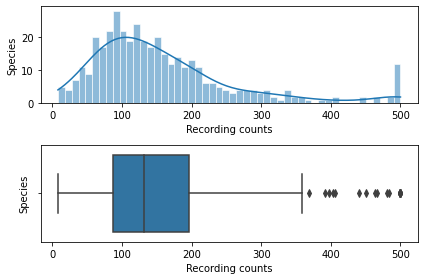

In [ ]:
rc_counts = df['common_name'].value_counts()
fig, ax = plt.subplots(2,1,tight_layout=True)
sns.histplot(data=rc_counts, kde=True, bins=50, edgecolor='white', ax=ax[0])
sns.boxplot(x=rc_counts, ax=ax[1])
ax[0].set_xlabel('Recording counts')
ax[0].set_ylabel('Species')
ax[1].set_xlabel('Recording counts')
ax[1].set_ylabel('Species')
# Most of the species have 100 to 200 samples

In [8]:
# Top 10 Most recorded species
df['common_name'].value_counts().head(10)

Red Crossbill              500
Common Raven               500
House Sparrow              500
Northern Cardinal          500
Barn Swallow               500
House Wren                 500
Song Sparrow               500
Gray-breasted Wood-Wren    500
European Starling          500
Spotted Towhee             500
Name: common_name, dtype: int64

In [ ]:
# Top 10 least recorded species
df['common_name'].value_counts().tail(10)

Ruby-throated Hummingbird     34
Gray-headed Chachalaca        22
Hepatic Tanager               22
Flame-rumped Tanager          19
Hoffmann's Woodpecker         18
White-crowned Parrot          12
White-eared Ground-Sparrow    10
Rufous-naped Wren              9
Crimson-fronted Parakeet       8
Steely-vented Hummingbird      8
Name: common_name, dtype: int64

In [ ]:
# By rank
df['common_name'].value_counts().rank(pct=True)

Red Crossbill                 0.986146
Common Raven                  0.986146
House Sparrow                 0.986146
Northern Cardinal             0.986146
Barn Swallow                  0.986146
                                ...   
White-crowned Parrot          0.012594
White-eared Ground-Sparrow    0.010076
Rufous-naped Wren             0.007557
Crimson-fronted Parakeet      0.003778
Steely-vented Hummingbird     0.003778
Name: common_name, Length: 397, dtype: float64

In [ ]:
(df['common_name'].value_counts()<=50).value_counts(normalize=True)*100
# 7% of species have less than 50 recordings

False    92.695214
True      7.304786
Name: common_name, dtype: float64

In [ ]:
(df['common_name'].value_counts()<=200).value_counts(normalize=True)*100
# 76% of species have between 50 and 200 recordings

True     76.070529
False    23.929471
Name: common_name, dtype: float64

In [ ]:
(df['common_name'].value_counts()>400).value_counts(normalize=True)*100
# 5% of species have more thatn 400 recordings

False    94.962217
True      5.037783
Name: common_name, dtype: float64

### Recorded time and season

#### Generate datetime column

In [ ]:
df.dtypes

primary_label        object
secondary_labels     object
type                 object
latitude            float64
longitude           float64
common_name          object
date                 object
filename             object
rating              float64
time                 object
dtype: object

In [ ]:
# Combine 'date' and 'time' into 'date_time' column, and change datatype to datetime
df['date_time'] = df['date']+' '+ df['time']
df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')
df.head()

,primary_label,secondary_labels,type,latitude,longitude,common_name,date,filename,rating,time,date_time
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Acadian Flycatcher,2012-08-12,XC109605.ogg,2.5,09:30,2012-08-12 09:30:00
1,acafly,[],['call'],9.1334,-79.6501,Acadian Flycatcher,2000-12-26,XC11209.ogg,3.0,?,NaT
2,acafly,[],['call'],5.7813,-75.7452,Acadian Flycatcher,2012-01-10,XC127032.ogg,3.0,15:20,2012-01-10 15:20:00
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Acadian Flycatcher,2009-06-19,XC129974.ogg,3.5,07:50,2009-06-19 07:50:00
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Acadian Flycatcher,2009-06-19,XC129981.ogg,3.5,07:50,2009-06-19 07:50:00


In [ ]:
# Count NaN values
df['date_time'].isna().value_counts()

# 4948 invalid datetime values in 'date_time' column

False    57926
True      4948
Name: date_time, dtype: int64

####  Plot recorded time and season

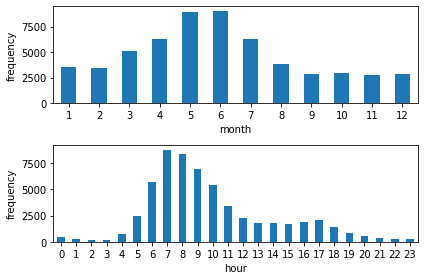

In [ ]:
fig, ax = plt.subplots(2,1,tight_layout=True)
mon_cnt = df['date_time'].dropna().dt.month
hr_cnt = df['date_time'].dropna().dt.hour

mon_cnt.value_counts().sort_index().plot.bar(xlabel='month', ylabel='frequency', ax=ax[0],rot=0)
hr_cnt.value_counts().sort_index().plot.bar(xlabel='hour', ylabel='frequency',ax=ax[1],rot=0)


In [ ]:
mon_cnt.value_counts(normalize=True).sort_index()[2:7].sum().round(3)*100
#61.6% of recordings taken place during March to June

61.6

In [ ]:
hr_cnt.value_counts(normalize=True).sort_index()[6:12].sum().round(3)*100
#66.5% of recordings taken place during dawn(6am) till noon(11am)

66.5

### Geographic distribution by species

In [ ]:
# Generate geographic data from latitude and longitude
geo_df = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.longitude, df.latitude))
geo_df.head()

,primary_label,secondary_labels,type,latitude,longitude,common_name,date,filename,rating,time,date_time,geometry
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Acadian Flycatcher,2012-08-12,XC109605.ogg,2.5,09:30,2012-08-12 09:30:00,POINT (-84.12500 35.38600)
1,acafly,[],['call'],9.1334,-79.6501,Acadian Flycatcher,2000-12-26,XC11209.ogg,3.0,?,NaT,POINT (-79.65010 9.13340)
2,acafly,[],['call'],5.7813,-75.7452,Acadian Flycatcher,2012-01-10,XC127032.ogg,3.0,15:20,2012-01-10 15:20:00,POINT (-75.74520 5.78130)
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Acadian Flycatcher,2009-06-19,XC129974.ogg,3.5,07:50,2009-06-19 07:50:00,POINT (-75.62830 4.67170)
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Acadian Flycatcher,2009-06-19,XC129981.ogg,3.5,07:50,2009-06-19 07:50:00,POINT (-75.62830 4.67170)


##### Plot recording coordinates on a map

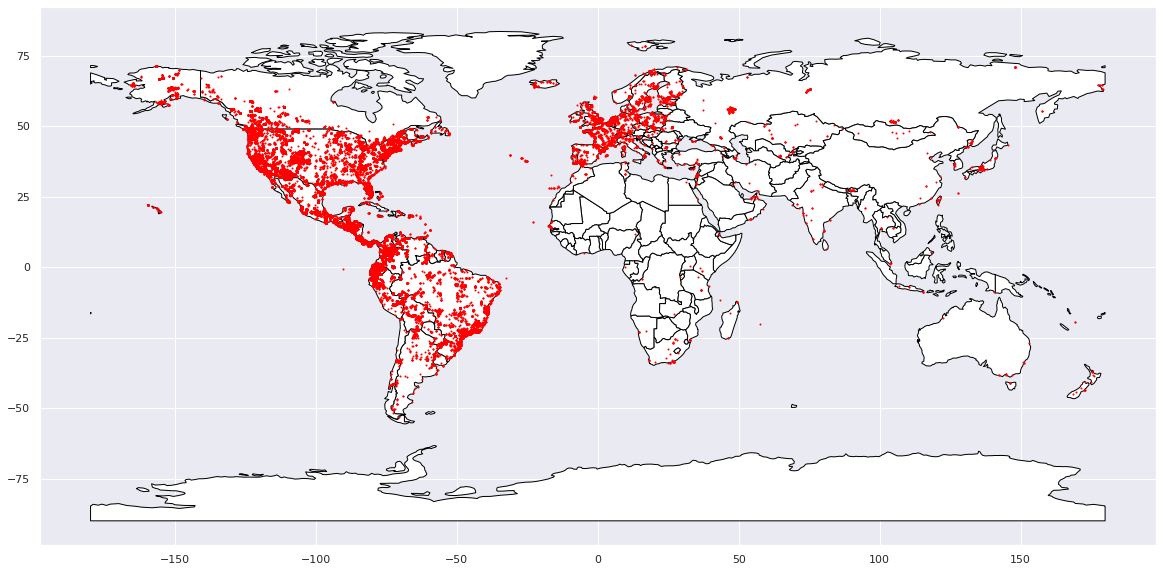

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(
    color='white', edgecolor='black', figsize=(20,14))
geo_df.plot(ax=ax, color='red',markersize=1)
# Major samples are taken from America and Europe regions

In [ ]:
# Plot spieces distribution in europe
fig = px.scatter_geo(df, lat='latitude',
                  lon='longitude', scope='europe', hover_name='common_name', color='common_name')

                    
fig.update_layout(title = 'Distribution of Bird Recordings', title_x=0.5)
fig.show()


Output hidden; open in https://colab.research.google.com to view.

##### Get coutries by coordinates

In [ ]:
geolocator = Nominatim(user_agent="geoapiExercises")

In [ ]:
def get_country(x):
    location = geolocator.reverse(f'{x.latitude},{x.longitude}')
    address = location.raw['address']
    if address:
        return address.get('country','')
    else:
        return 'no country'

In [ ]:
# Experiment geolocator with first 100 rows, due to the api cap 
df2 = df.head(100)
df2['country'] = df2[['latitude','longitude']].apply(get_country,axis=1)
df2['country'].dropna(inplace=True)
df2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:5258: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,primary_label,secondary_labels,type,latitude,longitude,common_name,date,filename,rating,time,date_time,geometry,country
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Acadian Flycatcher,2012-08-12,XC109605.ogg,2.5,09:30,2012-08-12 09:30:00,POINT (-84.12500 35.38600),United States
1,acafly,[],['call'],9.1334,-79.6501,Acadian Flycatcher,2000-12-26,XC11209.ogg,3.0,?,NaT,POINT (-79.65010 9.13340),Panamá
2,acafly,[],['call'],5.7813,-75.7452,Acadian Flycatcher,2012-01-10,XC127032.ogg,3.0,15:20,2012-01-10 15:20:00,POINT (-75.74520 5.78130),Colombia
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Acadian Flycatcher,2009-06-19,XC129974.ogg,3.5,07:50,2009-06-19 07:50:00,POINT (-75.62830 4.67170),Colombia
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Acadian Flycatcher,2009-06-19,XC129981.ogg,3.5,07:50,2009-06-19 07:50:00,POINT (-75.62830 4.67170),Colombia
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,acafly,[],['song'],9.2803,-70.7156,Acadian Flycatcher,2018-03-17,XC407863.ogg,5.0,12:54,2018-03-17 12:54:00,POINT (-70.71560 9.28030),Venezuela
96,acafly,[],['dusk song. sung on sucessive evenings by mor...,35.9486,-84.2009,Acadian Flycatcher,2018-05-21,XC416438.ogg,4.0,21:00,2018-05-21 21:00:00,POINT (-84.20090 35.94860),United States
97,acafly,"['scatan', 'bawwar', 'ovenbi1', 'norpar']",['song'],37.8170,-83.6814,Acadian Flycatcher,2018-05-04,XC416786.ogg,4.5,8:45,2018-05-04 08:45:00,POINT (-83.68140 37.81700),United States
98,acafly,[],['song'],40.8066,-73.4341,Acadian Flycatcher,2018-05-22,XC417181.ogg,4.5,08:30,2018-05-22 08:30:00,POINT (-73.43410 40.80660),United States


#### Group countries by continent

In [ ]:
cc

,country,code_2,code_3,country_code,iso_3166_2,continent,sub_region,region_code,sub_region_code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,142.0,34.0
1,ï¿½land Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,150.0,154.0
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,150.0,39.0
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,2.0,15.0
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,9.0,61.0
...,...,...,...,...,...,...,...,...,...
244,Wallis and Futuna,WF,WLF,876,ISO 3166-2:WF,Oceania,Polynesia,9.0,61.0
245,Western Sahara,EH,ESH,732,ISO 3166-2:EH,Africa,Northern Africa,2.0,15.0
246,Yemen,YE,YEM,887,ISO 3166-2:YE,Asia,Western Asia,142.0,145.0
247,Zambia,ZM,ZMB,894,ISO 3166-2:ZM,Africa,Eastern Africa,2.0,14.0


In [ ]:
cc = cc[['country','continent']]

In [ ]:
# Merge df2 with continent dataframe
df2.merge(cc, how='left', on='country')

,primary_label,secondary_labels,type,latitude,longitude,common_name,date,filename,rating,time,date_time,geometry,country,continent
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Acadian Flycatcher,2012-08-12,XC109605.ogg,2.5,09:30,2012-08-12 09:30:00,POINT (-84.12500 35.38600),United States,Americas
1,acafly,[],['call'],9.1334,-79.6501,Acadian Flycatcher,2000-12-26,XC11209.ogg,3.0,?,NaT,POINT (-79.65010 9.13340),Panamá,NaN
2,acafly,[],['call'],5.7813,-75.7452,Acadian Flycatcher,2012-01-10,XC127032.ogg,3.0,15:20,2012-01-10 15:20:00,POINT (-75.74520 5.78130),Colombia,Americas
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Acadian Flycatcher,2009-06-19,XC129974.ogg,3.5,07:50,2009-06-19 07:50:00,POINT (-75.62830 4.67170),Colombia,Americas
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Acadian Flycatcher,2009-06-19,XC129981.ogg,3.5,07:50,2009-06-19 07:50:00,POINT (-75.62830 4.67170),Colombia,Americas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,acafly,[],['song'],9.2803,-70.7156,Acadian Flycatcher,2018-03-17,XC407863.ogg,5.0,12:54,2018-03-17 12:54:00,POINT (-70.71560 9.28030),Venezuela,Americas
96,acafly,[],['dusk song. sung on sucessive evenings by mor...,35.9486,-84.2009,Acadian Flycatcher,2018-05-21,XC416438.ogg,4.0,21:00,2018-05-21 21:00:00,POINT (-84.20090 35.94860),United States,Americas
97,acafly,"['scatan', 'bawwar', 'ovenbi1', 'norpar']",['song'],37.8170,-83.6814,Acadian Flycatcher,2018-05-04,XC416786.ogg,4.5,8:45,2018-05-04 08:45:00,POINT (-83.68140 37.81700),United States,Americas
98,acafly,[],['song'],40.8066,-73.4341,Acadian Flycatcher,2018-05-22,XC417181.ogg,4.5,08:30,2018-05-22 08:30:00,POINT (-73.43410 40.80660),United States,Americas


### File size 

In [ ]:
# Get path for each audio data
df['rel_path'] = '/' + df['primary_label'].astype(str) + '/' + df['filename'].astype(str)
df['path'] = AUDIO_PATH + '/' + df['rel_path']

In [ ]:
# Get filesize for each audio data
df['filesize'] = df['path'].apply(os.path.getsize) * 0.001
df.head()

,primary_label,secondary_labels,type,latitude,longitude,common_name,date,filename,rating,time,date_time,geometry,rel_path,path,filesize
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Acadian Flycatcher,2012-08-12,XC109605.ogg,2.5,09:30,2012-08-12 09:30:00,POINT (-84.12500 35.38600),/acafly/XC109605.ogg,/content/drive/Shareddrives/Detecting bird sou...,745.0
1,acafly,[],['call'],9.1334,-79.6501,Acadian Flycatcher,2000-12-26,XC11209.ogg,3.0,?,NaT,POINT (-79.65010 9.13340),/acafly/XC11209.ogg,/content/drive/Shareddrives/Detecting bird sou...,215.0
2,acafly,[],['call'],5.7813,-75.7452,Acadian Flycatcher,2012-01-10,XC127032.ogg,3.0,15:20,2012-01-10 15:20:00,POINT (-75.74520 5.78130),/acafly/XC127032.ogg,/content/drive/Shareddrives/Detecting bird sou...,539.0
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Acadian Flycatcher,2009-06-19,XC129974.ogg,3.5,07:50,2009-06-19 07:50:00,POINT (-75.62830 4.67170),/acafly/XC129974.ogg,/content/drive/Shareddrives/Detecting bird sou...,167.0
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Acadian Flycatcher,2009-06-19,XC129981.ogg,3.5,07:50,2009-06-19 07:50:00,POINT (-75.62830 4.67170),/acafly/XC129981.ogg,/content/drive/Shareddrives/Detecting bird sou...,482.0


In [ ]:
# Normalizing
df['filesize'] = df['filesize'].round()

In [ ]:
df['filesize'].sort_values()
# Size of audio files vary from 6kb to 32mb

16324        6.0
29909        9.0
20567       15.0
1208        22.0
2859        26.0
          ...   
41027    23765.0
17580    27032.0
21843    27434.0
7426     32126.0
58201    32181.0
Name: filesize, Length: 62874, dtype: float64

Text(0, 0.5, 'Sample count')

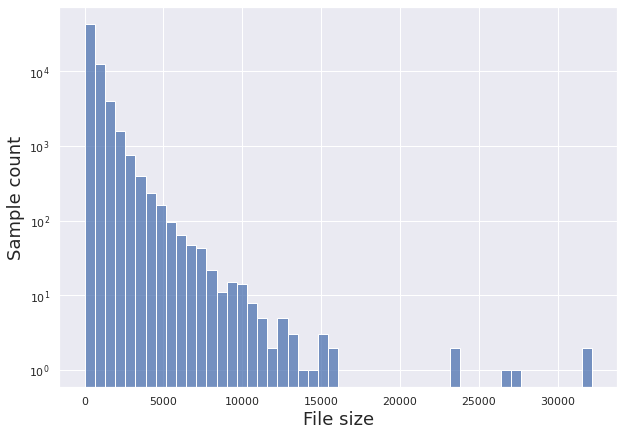

In [ ]:
# Histogram of 'filesize' colum
sns.set(rc={'figure.figsize':(10,7)})
sns.histplot(data=df['filesize'], bins=50, edgecolor='white', stat='count', log_scale=(False,True))

plt.xlabel('File size',fontdict={'fontsize':18})
plt.ylabel('Sample count', fontdict={'fontsize':18})

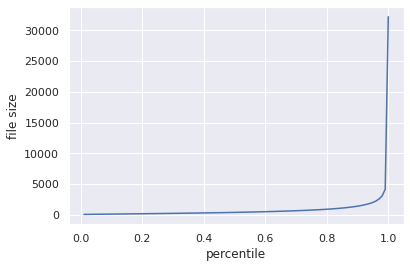

In [ ]:
# Percentile for 'filesize' colum
df['filesize'].quantile(q=np.arange(0.01,1.01,0.01), interpolation='linear').plot(ylabel='file size', xlabel='percentile' )
# More than 95% of files are smaller than 5000kb

### Rating


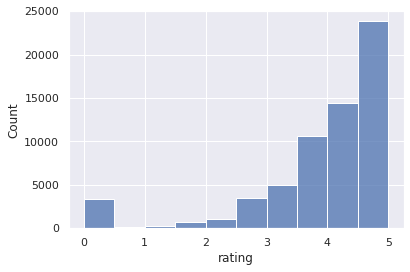

In [ ]:
sns.set(rc={'figure.figsize':(6,4)})
sns.histplot(data=df['rating'], binwidth=0.5)
# The majority of samples is rated with 3.5 or higher